<a href="https://colab.research.google.com/github/Loop3D/Kalgoorlie_3Dmodelling/blob/main/report_files_stratigraphy/04_SB1_faults.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if 'google.colab' in str(get_ipython()):
      !git clone https://github.com/Loop3D/Kalgoorlie_fault_network.git
      %cd Kalgoorlie_fault_network/report_files_faults
      !pip install git+https://github.com/Loop3D/LoopProjectFile.git
      !pip install git+https://github.com/Loop3D/map2loop-2.git
      !pip install git+https://github.com/Loop3D/LoopStructural@v1.5.4
      !pip install lavavu-osmesa geopandas meshio rasterio owslib

else:
      print('Not running on CoLab, nothing to do')

Not running on CoLab, nothing to do


In [16]:
#downloads the dem as a tif file from the WCS server

from owslib.wcs import WebCoverageService as w

wcs = w(url="http://services.ga.gov.au/site_9/services/DEM_SRTM_1Second_over_Bathymetry_Topography/MapServer/WCSServer?", 
        version = "1.0.0")

test = wcs.getCoverage(identifier = "1", bbox = (214793, 6501886, 400412, 6653022), 
                      format="GeoTIFF", crs = 28351, width=200, height=200)

file = open("./data/dem.tif", 'wb')
file.write(test.read())
file.close()

In [3]:
import geopandas as gpd
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer, RotationAnglePlotter
from LoopStructural.modelling import ProcessInputData
from LoopStructural.utils import dtm_creator

path_data = r"./data"
path_DEM = r"./data/dem.tif"

In [4]:
updated_data = pd.read_csv(os.path.join(path_data, "LoopStructural_data/updated_data_cropped_SB1.csv"))
updated_oris = pd.read_csv(os.path.join(path_data, "LoopStructural_data/updated_oris.csv"))

In [5]:
origin = [278590.2226191017543897,6598684.8566970974206924, -40000]
maximum = [349951.3870649862801656,6654101.1388352485373616, 5000]

# Add new fault as F1

In [6]:
pts_fault = gpd.read_file(os.path.join(path_data, "faults/new_fault_pts.shp"))
pts_fault = pd.DataFrame({
    'X': pts_fault.geometry.x, 
    'Y': pts_fault.geometry.y, 
    'Z': pts_fault['DEM'],
    'fault_name': pts_fault.name
})

# calculate ori per fault 
pts_fault_f1 = pts_fault[pts_fault['fault_name']=='F1'].reset_index(drop=True)

ori1 = []
centre = pts_fault_f1[["X", "Y", "Z"]].mean().to_numpy().tolist()
tangent = (pts_fault_f1[["X", "Y", "Z"]].to_numpy()[0, :]  - pts_fault_f1[["X", "Y", "Z"]].to_numpy()[-1, :])
norm = tangent / np.linalg.norm(tangent)
norm = norm.dot(np.array([[0, 1, 0], [0, 0, 0], [0, 0, 1]]))
ori1.append(["F1", *centre, *norm])
ori1 = pd.DataFrame(ori1, columns=["fault_name", "X", "Y", "Z", "gx", "gy", "gz"])

updated_o = pd.concat([ori1, updated_oris]).reset_index(drop=True)
updated_data = pd.concat([updated_data, pts_fault_f1]).reset_index(drop=True)

In [7]:
# on the updated oris, the gradient coinstraints for the faults were calculated 
# from the long faults that were originally in the map. Need to recalculate the average x, y and z for each fault
# from the cropped data

oris = updated_o[(updated_o['fault_name']=='Black Flag Fault') | (updated_o['fault_name']=='Boorara Fault') |
                (updated_o['fault_name']=='F1') | (updated_o['fault_name']=='F2') | 
                 (updated_o['fault_name']=='Zuleika Fault')]
oris = oris.reset_index(drop=True)
names = oris['fault_name']

In [8]:
means_x = []
means_y = []

for fault in names:
    means_x.append(
        pd.DataFrame(
            updated_data[(updated_data['fault_name']==fault) & (updated_data['Z']>0)][['X', 'Y', 'Z']].mean()).T)
    
xyzs = pd.concat(means_x).reset_index(drop=True)

new_ori = pd.DataFrame({
    'fault_name': names, 
    'X': xyzs['X'], 'Y': xyzs['Y'], 'Z': xyzs['Z'], 
    'gx': oris['gx'], 'gy': oris['gy'], 'gz': oris['gz'],  
    
})
new_ori

,fault_name,X,Y,Z,gx,gy,gz
0,F1,321630.617951,6.630260e+06,429.521739,0.000000,-0.910395,-0.002140
1,Zuleika Fault,303070.507700,6.630769e+06,416.632184,-0.387965,-0.203100,-0.899018
2,Boorara Fault,335444.160224,6.640885e+06,414.073428,0.427567,0.191523,-0.883462
3,Boorara Fault,335444.160224,6.640885e+06,414.073428,0.427567,0.191523,-0.883462
4,Black Flag Fault,332297.738343,6.623995e+06,393.251108,0.914072,-0.197922,0.169378


In [9]:
processor = ProcessInputData(
    origin=origin,
    maximum=maximum, 
    fault_locations = updated_data, 
    fault_orientations = new_ori
)

                This will result in only a fault surface, no displacement on older features


In [12]:
model = GeologicalModel(processor.origin, processor.maximum)
model.data = processor.data
# model.dtm = dtm_creator.create_dtm_with_rasterio(path_DEM) 

# model.stratigraphic_column = processor.stratigraphic_column
# model.nsteps = [100, 100, 200]
model.create_and_add_fault('Zuleika Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cpw = .05)
model.create_and_add_fault('Boorara Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True), 
#                            cpw = 0.2, regularisation = [5, 5, 5])
# model['Boorara Fault'].builder.set_mesh_geometry(0.1, 0)


model.create_and_add_fault('Black Flag Fault', displacement = 5000, nelements=1e4, force_mesh_geometry = False)
model.create_and_add_fault('F1', displacement = 5000, nelements=1e4, force_mesh_geometry = True)
model['F1'].builder.set_mesh_geometry(0.1, 0)

tang1 = np.tile([-1737.07, -2023.51,  7009.83],
                (model['Black Flag Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Black Flag Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Black Flag Fault'][0].interpolator.support.barycentre,
                vector = tang1, w=1, B=0)

model['Black Flag Fault'].add_abutting_fault(model['Boorara Fault'])
model['Black Flag Fault'].add_abutting_fault(model['Zuleika Fault'])
model['Zuleika Fault'].add_abutting_fault(model['Boorara Fault'])
model['F1'].add_abutting_fault(model['Boorara Fault'])
model['F1'].add_abutting_fault(model['Zuleika Fault'])

model.update()

  0%|          | 0/12 [00:00<?, ?it/s]


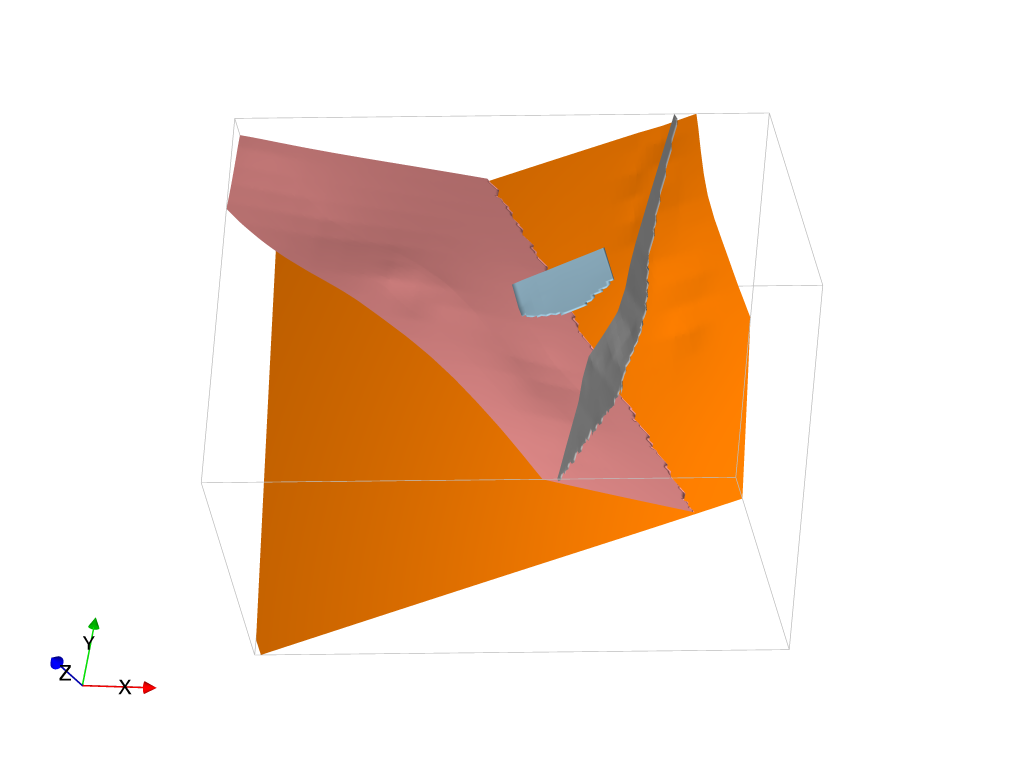

In [13]:
view = LavaVuModelViewer(model)

view.nelements = 1e6
view.add_isosurface(model['Black Flag Fault'], colours = ['grey'], value = 0)
view.add_isosurface(model['Boorara Fault'], colours = ['#ff7f00'], value = 0)
view.add_isosurface(model['Zuleika Fault'], colours = ['#fb9a99'], value = 0)

view.add_isosurface(model['F1'], colours = ['#a6cee3'], value = 0)

# view.interactive()
view.rotation = [-30.30629539489746, -10.07066822052002, 0.5780797600746155]
view.display()


In [20]:
model = GeologicalModel(processor.origin, processor.maximum)
model.data = processor.data
# model.dtm = dtm_creator.create_dtm_with_rasterio(path_DEM) 

# model.stratigraphic_column = processor.stratigraphic_column
model.nsteps = [200, 200, 300]
model.create_and_add_fault('Zuleika Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cpw = .05)
model.create_and_add_fault('Boorara Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True), 
#                            cpw = 0.2, regularisation = [5, 5, 5])
# model['Boorara Fault'].builder.set_mesh_geometry(0.1, 0)


model.create_and_add_fault('Black Flag Fault', displacement = 5000, nelements=1e4, force_mesh_geometry = False)
model.create_and_add_fault('F1', displacement = 5000, nelements=1e4, force_mesh_geometry = True)
model['F1'].builder.set_mesh_geometry(0.1, 0)

tang1 = np.tile([-1737.07, -2023.51,  7009.83],
                (model['Black Flag Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Black Flag Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Black Flag Fault'][0].interpolator.support.barycentre,
                vector = tang1, w=1, B=0)

model['Black Flag Fault'].add_abutting_fault(model['Boorara Fault'])
model['Black Flag Fault'].add_abutting_fault(model['Zuleika Fault'])
model['Zuleika Fault'].add_abutting_fault(model['Boorara Fault'])
model['F1'].add_abutting_fault(model['Boorara Fault'])
model['F1'].add_abutting_fault(model['Zuleika Fault'])


model.update()

  0%|          | 0/12 [00:00<?, ?it/s]


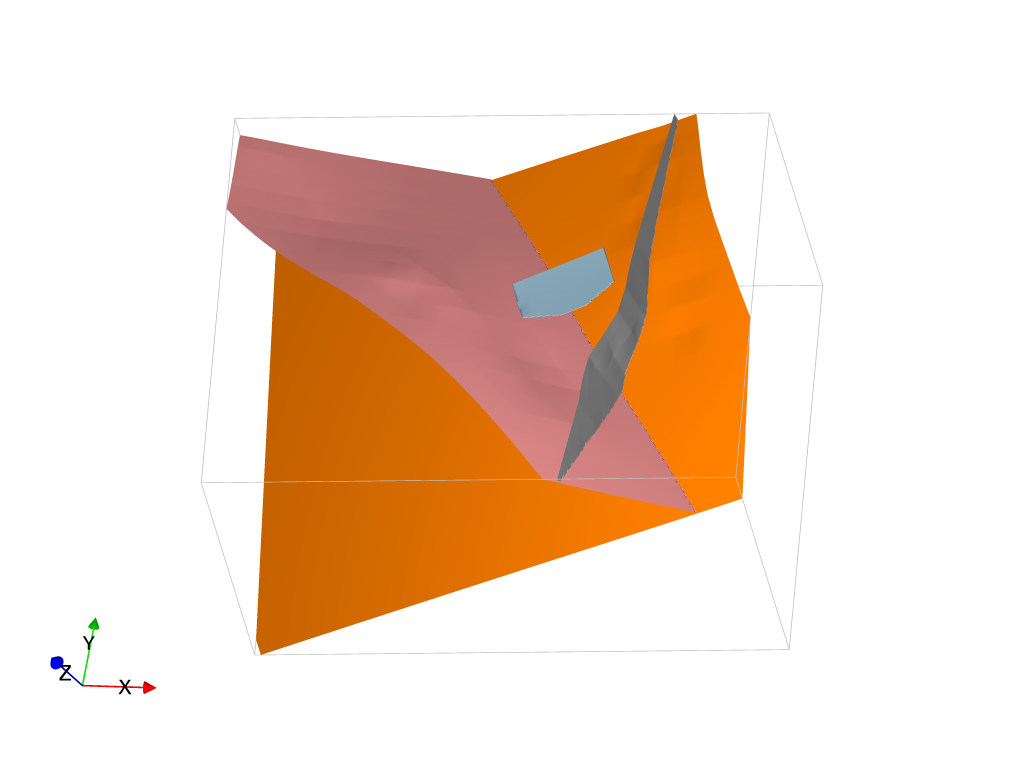

In [21]:
view = LavaVuModelViewer(model)

# view.nsteps = [200,200,300]
view.add_isosurface(model['Black Flag Fault'], colours = ['grey'], value = 0)
view.add_isosurface(model['Boorara Fault'], colours = ['#ff7f00'], value = 0)
view.add_isosurface(model['Zuleika Fault'], colours = ['#fb9a99'], value = 0)

view.add_isosurface(model['F1'], colours = ['#a6cee3'], value = 0)

# view.add_points(a, name = "jgv", pointsize=10)
# view.interactive()
view.rotation = [-30.30629539489746, -10.07066822052002, 0.5780797600746155]
view.display()

In [22]:
updated_data.to_csv(os.path.join(path_data, "./LoopStructural_data/updated_data_SB1.csv"), index=None)
new_ori.to_csv(os.path.join(path_data, "./LoopStructural_data/updated_ori_SB1.csv"), index=None)